# Project 1 Group 4
### Matthew Adent, Khalil Locke, Chase Mueller, Marcanthony Solorzano

## Setup

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

# Data Loading and Cleaning
filepath = 'data/Spotify_Youtube.csv'
data = pd.read_csv(filepath)
data = data.drop(columns=['Unnamed: 0', 'Url_spotify', 'Uri', 'Url_youtube', 'Description'])
data.info()
custom_palette = sns.color_palette(["#386641", "#BC4749", "#A7C957", "#F2E8CF", "#6A994E"])
sns.set_palette(custom_palette)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20718 non-null  object 
 1   Track             20718 non-null  object 
 2   Album             20718 non-null  object 
 3   Album_type        20718 non-null  object 
 4   Danceability      20716 non-null  float64
 5   Energy            20716 non-null  float64
 6   Key               20716 non-null  float64
 7   Loudness          20716 non-null  float64
 8   Speechiness       20716 non-null  float64
 9   Acousticness      20716 non-null  float64
 10  Instrumentalness  20716 non-null  float64
 11  Liveness          20716 non-null  float64
 12  Valence           20716 non-null  float64
 13  Tempo             20716 non-null  float64
 14  Duration_ms       20716 non-null  float64
 15  Title             20248 non-null  object 
 16  Channel           20248 non-null  object

## Question 1: How do the features differ between the top 10% songs of Youtube and Spotify?

P-Value: 0.018
The difference in average acousticness in the top 15% of Spotify vs YouTube songs is statistically significant.

Feature Means by Platform:


,Platform,Danceability,Energy,Loudness,Speechiness,Acousticness,Valence,Liveness,Tempo
0,Spotify,0.649855,0.661293,-6.438411,0.095405,0.216407,0.524071,0.177659,121.120469
1,YouTube,0.659846,0.677289,-6.087433,0.094407,0.230838,0.548021,0.191912,121.907129


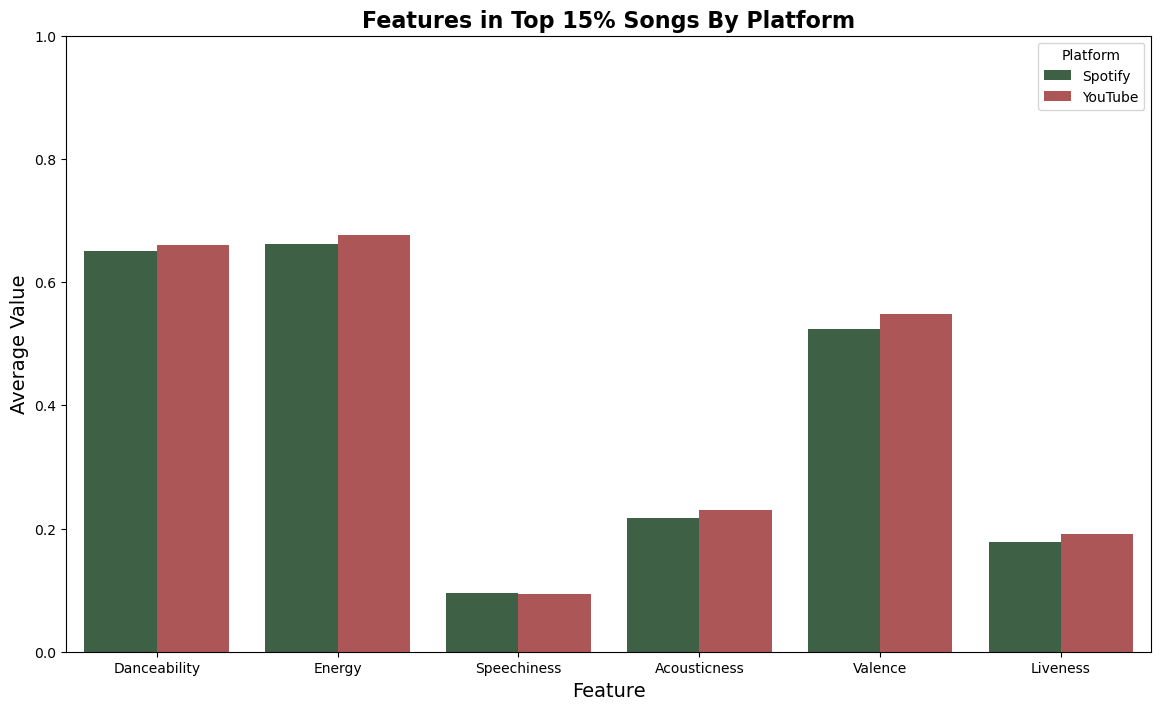

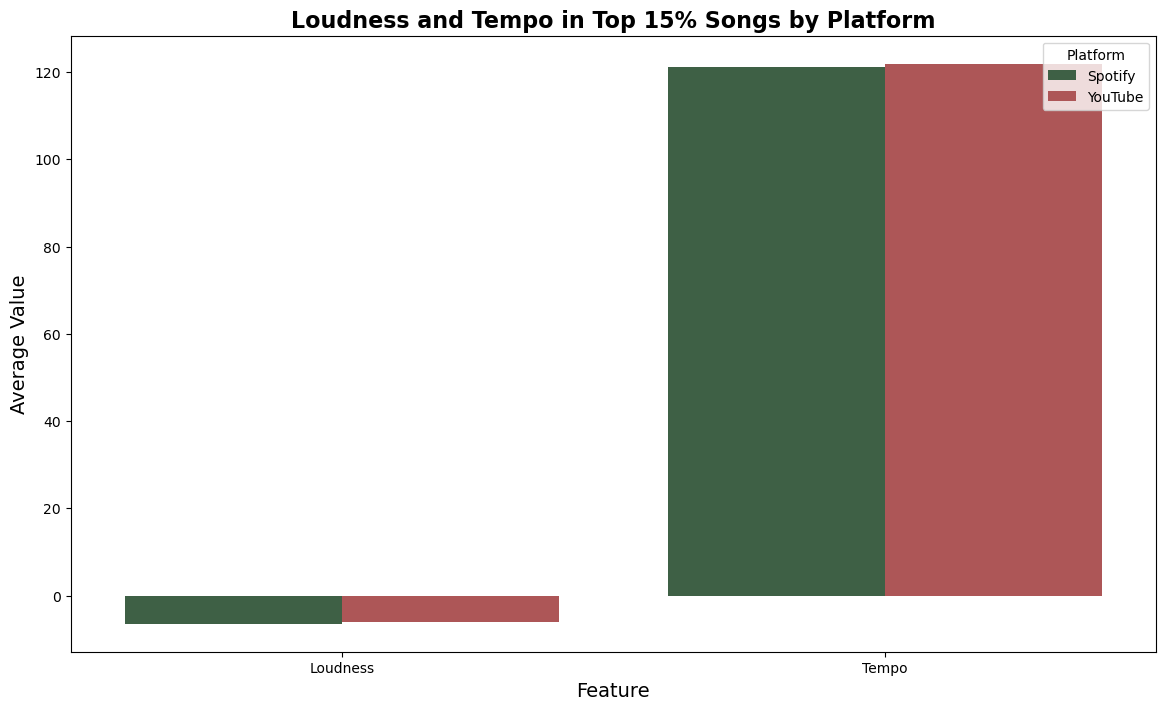

In [5]:
# Define what high views/streams are, then find songs that meet that criteria
threshold_views = data['Views'].quantile(0.85) # 85th percentile aka top 15%
threshold_streams = data['Stream'].quantile(0.85)
top_youtube = data[data['Views'] >= threshold_views].copy() # pandas was mad when I tried to set top_youtube to a view, so I made it a copy instead
top_youtube['Platform'] = 'YouTube'
top_spotify = data[data['Stream'] >= threshold_streams].copy()
top_spotify['Platform'] = 'Spotify'

# T-test
# Null hypothesis: The difference between the average of acousticness in the top 15% of youtube and spotify songs in this data is insignificant
youtube_acousticness = top_youtube['Acousticness']
spotify_acousticness = top_spotify['Acousticness']

# Perform an independent t-test
t_stat, p_value = ttest_ind(youtube_acousticness, spotify_acousticness, equal_var=True)

# Print the results
print(f"P-Value: {p_value:.3f}")
if p_value < 0.05: 
    # Strong evidence against null hypothesis
    print("The difference in average acousticness in the top 15% of Spotify vs YouTube songs is statistically significant.")
else:
    # Null hypothesis supported
    print("The difference in average acousticness in the top 15% of Spotify vs YouTube songs is not statistically significant.")

# Get the means for all the top 15% songs
top_combined = pd.concat([top_youtube, top_spotify])
features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence', 'Liveness', 'Tempo']
feature_means = top_combined.groupby('Platform')[features].mean().reset_index()

# Show exact values
print()
print("Feature Means by Platform:")
display(feature_means)

# We need the data to be in something called long-format for seaborn
feature_means = feature_means.melt(id_vars='Platform', var_name='Feature', value_name='Value')

# Visualization using Seaborn
# Tempo and platform have a large difference in ranges compared to every other feature, so I put them on a separate graph to avoid warping

subset_features_1 = feature_means[~feature_means['Feature'].isin(['Loudness', 'Tempo'])] # ~ is logical not apparently. I think ! is better but whatever.
plt.figure(figsize=(14, 8))
sns.barplot(data=subset_features_1, x='Feature', y='Value', hue='Platform', errorbar=None)
plt.title('Features in Top 15% Songs By Platform', fontsize=16, weight='bold')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Platform', loc='upper right')
plt.ylim(0, 1)
plt.show()

subset_features_2 = feature_means[feature_means['Feature'].isin(['Loudness', 'Tempo'])]
plt.figure(figsize=(14, 8))
sns.barplot(data=subset_features_2, x='Feature', y='Value', hue='Platform', errorbar=None)
plt.title('Loudness and Tempo in Top 15% Songs by Platform', fontsize=16, weight='bold')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Platform', loc='upper right')
plt.show()

## Question 2: How are the emotional tones of top-streamed and most-viewed songs distributed? 

In [7]:
# Data cleaning
df = data.drop(columns=["Album", "Album_type", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness",  
                        "Liveness", "Tempo", "Duration_ms", "Channel", "Comments", "Licensed", "official_video", "Likes"])
df = df.dropna(how="any")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19691 entries, 0 to 20717
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist        19691 non-null  object 
 1   Track         19691 non-null  object 
 2   Danceability  19691 non-null  float64
 3   Energy        19691 non-null  float64
 4   Valence       19691 non-null  float64
 5   Title         19691 non-null  object 
 6   Views         19691 non-null  float64
 7   Stream        19691 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.4+ MB


In [8]:
# Define popular songs (15%) using quantiles
popular_streams = df["Stream"].quantile(0.85)
popular_views = df["Views"].quantile(0.85)

df2 = df.loc[(df["Stream"] >= popular_streams) & (df["Views"] >= popular_views)]
#df2 = df.loc[df["Views"] >= popular_views]
df2.head(10)

,Artist,Track,Danceability,Energy,Valence,Title,Views,Stream
0,Gorillaz,Feel Good Inc.,0.818,0.705,0.772,Gorillaz - Feel Good Inc. (Official Video),6.935552e+08,1.040235e+09
3,Gorillaz,On Melancholy Hill,0.689,0.739,0.578,Gorillaz - On Melancholy Hill (Official Video),2.117550e+08,4.346636e+08
4,Gorillaz,Clint Eastwood,0.663,0.694,0.525,Gorillaz - Clint Eastwood (Official Video),6.184810e+08,6.172597e+08
5,Gorillaz,DARE,0.760,0.891,0.966,Gorillaz - DARE (Official Video),2.590212e+08,3.238503e+08
10,Red Hot Chili Peppers,Californication,0.592,0.767,0.328,Red Hot Chili Peppers - Californication (Offic...,1.018811e+09,1.055738e+09
11,Red Hot Chili Peppers,Under the Bridge,0.559,0.345,0.458,Red Hot Chili Peppers - Under The Bridge [Offi...,2.466877e+08,1.061751e+09
12,Red Hot Chili Peppers,Can't Stop,0.618,0.938,0.875,Red Hot Chili Peppers - Can't Stop [Official M...,3.366358e+08,8.664650e+08
13,Red Hot Chili Peppers,Scar Tissue,0.595,0.717,0.547,Red Hot Chili Peppers - Scar Tissue [Official ...,4.351215e+08,6.138387e+08
14,Red Hot Chili Peppers,Otherside,0.458,0.795,0.513,Red Hot Chili Peppers - Otherside [Official Mu...,6.735287e+08,7.327745e+08
15,Red Hot Chili Peppers,Snow (Hey Oh),0.427,0.900,0.599,Red Hot Chili Peppers - Snow (Hey Oh) (Officia...,3.208712e+08,8.607223e+08


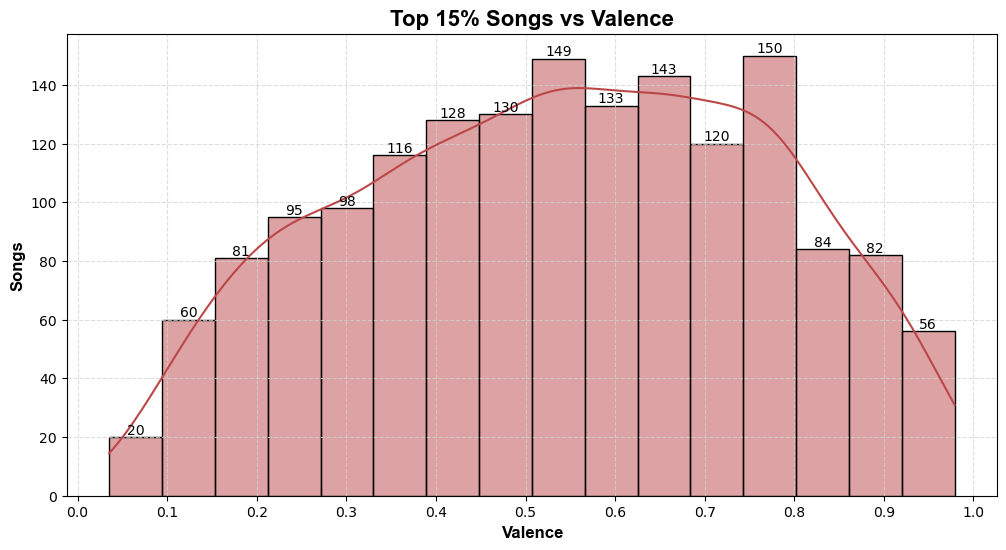

In [9]:
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Create a basic plot
sns.histplot(data=df2, x="Valence", kde=True, color="#BC4749")

# Add Labels/Title
plt.xlabel("Valence", fontfamily="Arial", fontweight="bold", fontsize=12)
plt.ylabel("Songs", fontfamily="Arial", fontweight="bold", fontsize=12)
plt.title("Top 15% Songs vs Valence", fontweight="bold", fontsize=16, fontfamily="Arial")

# Loop through the patches (bars) and add text labels
for p in plt.gca().patches:
    # Get the height of each bar (count)
    height = p.get_height()
    
    # Get the x-position of the bar (center of the bar)
    x_position = p.get_x() + p.get_width() / 2
    
    # Add the count as a label on top of the bar
    plt.text(x_position, height, str(int(height)), ha='center', va='bottom', fontsize=10)

# Change the interval from 0.2 to 0.1
plt.xticks([x * 0.1 for x in range(11)])

# Add in a background grid
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)

# Show/Save the Graph
plt.show()

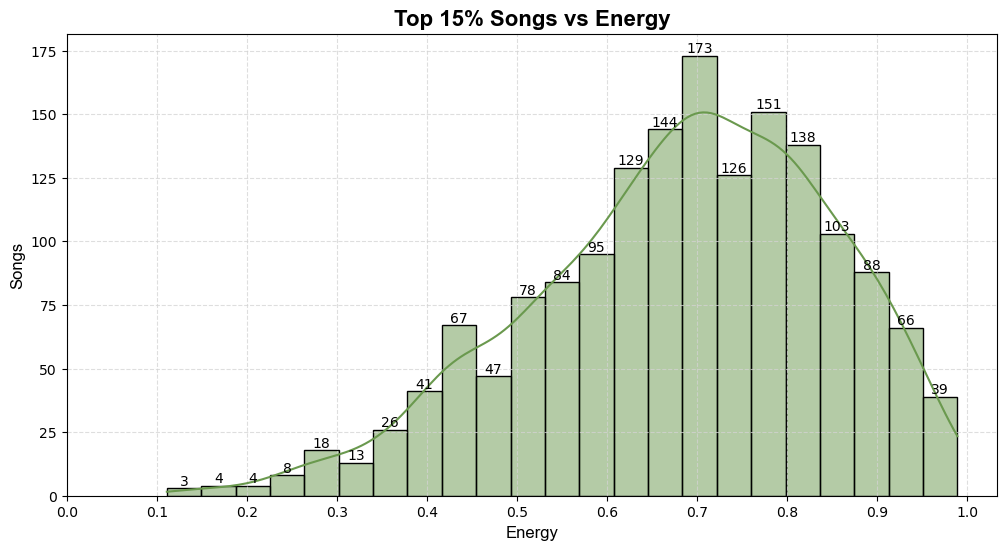

In [10]:
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Create a basic plot
sns.histplot(data=df2, x="Energy", kde=True, color="#6A994E")

# Add Labels/Title
plt.xlabel("Energy", fontfamily="Arial", fontsize=12)
plt.ylabel("Songs", fontfamily="Arial", fontsize=12)
plt.title("Top 15% Songs vs Energy", fontweight="bold", fontsize=16, fontfamily="Arial")

# Loop through the patches (bars) and add text labels
for p in plt.gca().patches:
    # Get the height of each bar (count)
    height = p.get_height()
    
    # Get the x-position of the bar (center of the bar)
    x_position = p.get_x() + p.get_width() / 2
    
    # Add the count as a label on top of the bar
    plt.text(x_position, height, str(int(height)), ha='center', va='bottom', fontsize=10)

# Change the interval from 0.2 to 0.1
plt.xticks([x * 0.1 for x in range(11)])

# Add in a background grid
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)

# Show/Save the Graph
plt.show()

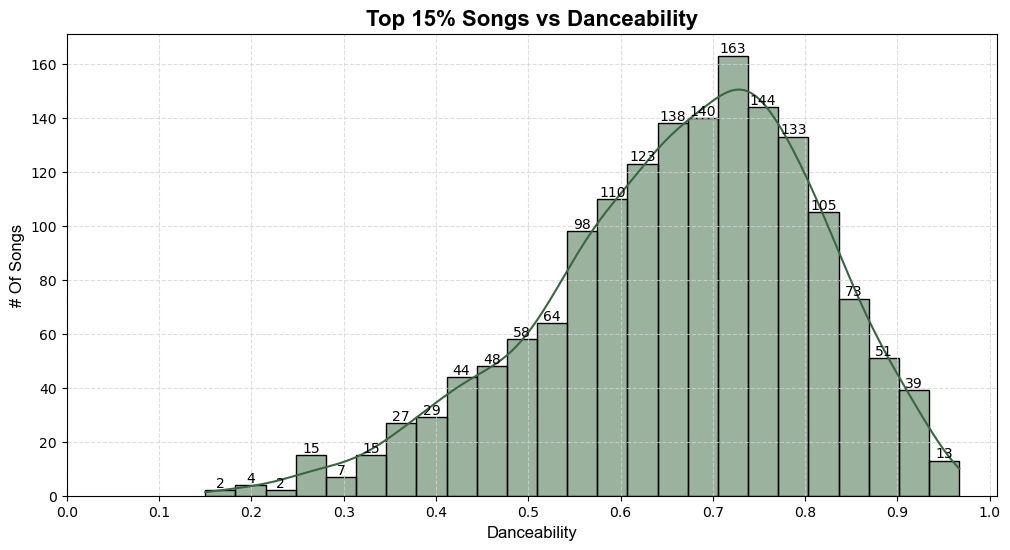

In [11]:
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Create a basic plot
sns.histplot(data=df2, x="Danceability", kde=True, color="#386641")

# Add Labels/Title
plt.xlabel("Danceability", fontfamily="Arial", fontsize=12)
plt.ylabel("# Of Songs", fontfamily="Arial", fontsize=12)
plt.title("Top 15% Songs vs Danceability", fontweight="bold", fontsize=16, fontfamily="Arial")

# Loop through the patches (bars) and add text labels
for p in plt.gca().patches:
    # Get the height of each bar (count)
    height = p.get_height()
    
    # Get the x-position of the bar (center of the bar)
    x_position = p.get_x() + p.get_width() / 2
    
    # Add the count as a label on top of the bar
    plt.text(x_position, height, str(int(height)), ha='center', va='bottom', fontsize=10)

# Change the interval from 0.2 to 0.1
plt.xticks([x * 0.1 for x in range(11)])

# Add in a background grid
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)

# Show/Save the Graph
plt.show()

In [12]:
correlation = df2[["Valence", "Energy", "Danceability"]].corr()
correlation

,Valence,Energy,Danceability
Valence,1.000000,0.343067,0.402326
Energy,0.343067,1.000000,-0.002059
Danceability,0.402326,-0.002059,1.000000


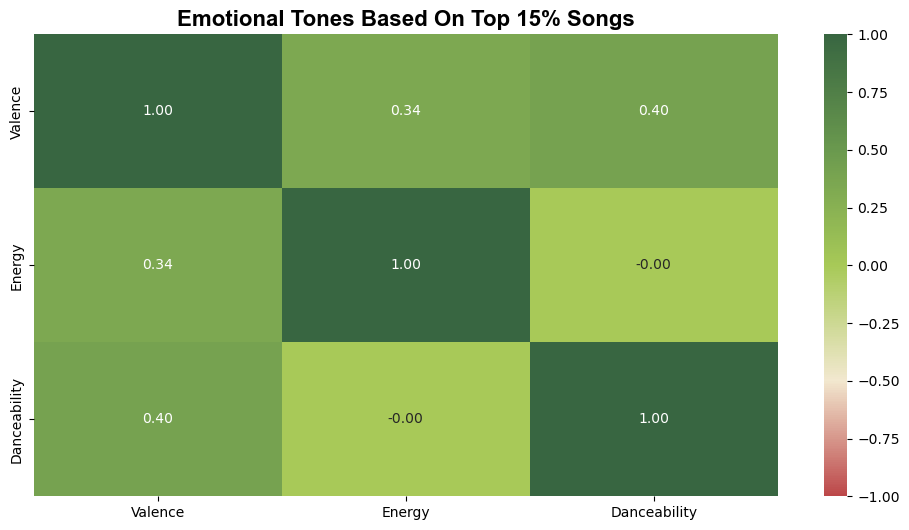

In [13]:
# Change Canvas Size
plt.figure(figsize=(12, 6))

#Define your custom color palette
colors = ["#BC4749", "#F2E8CF", "#A7C957", "#6A994E", "#386641"]
custom_palette = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Create a basic plot with the color bar indicator
sns.heatmap(correlation, annot=True, cmap=custom_palette, fmt='.2f', vmin=-1, vmax=1)

# Customization
plt.title("Emotional Tones Based On Top 15% Songs", fontweight="bold", fontsize=16, fontfamily="Arial",)

# Show/Save the Graph
plt.show()

## Question 3: What kind of correlation do the features of a song have with each other?

In [15]:
# Looking to see if there is a correlation between the danceability, energy, loudness, speechiness, acousticness, and instrumentalness
# liveness, and valence contribute to a difference in streams across YouTube and Spotify.

# Visualization - Heatmap

In [16]:
# Data Loading and Cleaning
filepath = 'data/Spotify_Youtube.csv'
data = pd.read_csv(filepath)
data = data.drop(columns=['Unnamed: 0', 'Url_spotify', 'Uri', 'Url_youtube', 'Description'])
custom_palette = sns.color_palette(["#BC4749", "#F2E8CF", "#A7C957", "#6A994E", "#386641"]) #adjusting for heatmap. Order maps bottom up on heatmap

sns.set_palette(custom_palette)

In [17]:
# drop null values
df = data.dropna(how="any")

# drop 2, 3, 6, 13, 14, 16 18, 19, 20, and 21.
df2_test = df.drop(columns=["Album", "Album_type", "Key", "Tempo", "Duration_ms", "Channel", "Likes", "Comments", "Licensed", "official_video", "Title"])

# drop any characters that are non-english for the artist name for cleanliness
df2 = df2_test[df2_test['Artist'].str.contains(r'^[a-zA-Z\s]+$', na=False)]

# convert Views and streams to non-scientific notation values
df2.loc[:, ['Views', 'Stream']] = df2[['Views', 'Stream']].apply(lambda x: x.apply(lambda y: '{:.2f}'.format(y)))


C:\Users\matth\AppData\Local\Temp\ipykernel_28164\3374351524.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['693555221.00' '72011645.00' '8435055.00' ... '35646.00' '6533.00'
 '158697.00']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df2.loc[:, ['Views', 'Stream']] = df2[['Views', 'Stream']].apply(lambda x: x.apply(lambda y: '{:.2f}'.format(y)))
C:\Users\matth\AppData\Local\Temp\ipykernel_28164\3374351524.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1040234854.00' '310083733.00' '63063467.00' ... '6226110.00'
 '6873961.00' '5695584.00']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df2.loc[:, ['Views', 'Stream']] = df2[['Views', 'Stream']].apply(lambda x: x.apply(lambda y: '{:.2f}'.format(y)))


In [18]:
#1. Streams and Views: Why Analyze Them Together?
#Complementary Measures of Popularity:
#Streams represent audio-only consumption, while Views incorporate a visual component. By analyzing them together, you can understand whether a song’s attributes influence its popularity across different platform types.
#Example: A song might do well in Streams because it’s great for playlists, but it might not perform as well in Views if it lacks a compelling visual element.
#Platform-Specific Insights:
#Streams and Views allow us to compare trends across audio-centric platforms (Spotify, Apple Music) and video-centric platforms (YouTube). By studying both, you can identify if certain song attributes (e.g., Danceability or Energy) universally drive popularity or are platform-specific.
#Example: A high-energy dance track might excel in both Streams and Views if it inspires dance trends but might show stronger effects on Views due to its shareability in videos.



In [19]:
####################################################################################################################################################################################

In [20]:
# Start org_1 for data viz
# First, I want to group the artists by views and artists by streams to see the different artist counts -- create a bar chart for VIZ and reference.
# This way, we can compare the Views and Stream for a random sampling of artists. 5-10 Max.

# Second, I 

In [21]:
# create org_1 df to aggregate the artists in str

org_1 = df2.groupby('Artist').agg({
    'Views': 'sum',
    'Stream': 'sum'
}).reset_index()

# Ensure 'Views' and 'Stream' columns are numeric
org_1['Views'] = pd.to_numeric(df2['Views'], errors='coerce')
org_1['Stream'] = pd.to_numeric(df2['Stream'], errors='coerce')

org_1 = org_1.dropna(how="any")

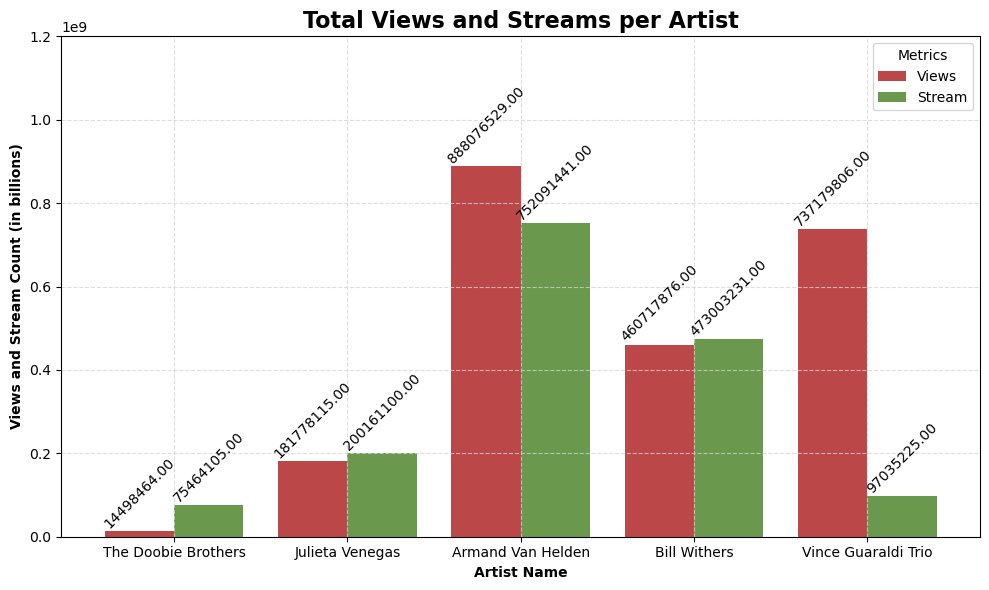

In [22]:
# Get a random sample of 10 artists from the org_1 DataFrame
random_sample_artists = org_1.sample(n=5, random_state=1)  # random_state for reproducibility

# Set the index to 'Artist' for plotting
random_sample_artists.set_index('Artist', inplace=True)

# Convert columns to numeric if necessary
random_sample_artists['Views'] = pd.to_numeric(random_sample_artists['Views'], errors='coerce')
random_sample_artists['Stream'] = pd.to_numeric(random_sample_artists['Stream'], errors='coerce')

# Check the data types again after conversion
random_sample_artists.describe()

# Select only numeric columns for plotting
random_sample_artists_numeric = random_sample_artists[["Views", "Stream"]]

# Plotting
ax = random_sample_artists_numeric.plot(kind='bar', figsize=(10, 6), width=0.8, color=['#BC4749','#6A994E'])

# Set display format for the y-axis to non-scientific notation
for label in ax.get_yticklabels():
    try:
        label_text = label.get_text().replace('−', '-')
        label.set_text('{:.2f}'.format(float(label_text)))
    except ValueError:
        pass

# Display values at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', rotation=45)

plt.title('Total Views and Streams per Artist', fontsize=16, fontweight="bold")
plt.xlabel("Artist Name", fontweight="bold")
plt.ylabel("Views and Stream Count (in billions)",fontweight="bold")
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
plt.xticks(rotation=0)
plt.ylim(0,12e8)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [23]:
# Genres

# Doobie Brothers - Soft Rock
# Julieta Venegas - Latin Pop
# Armand Van Helden - EDM
# Bill Withers - R&B/Soul
# Vince Guaraldi Trio - Jazz

In [24]:
# HEATMAP
# Drop non-float values from the Dataset
df3 = df2.drop(columns=["Artist", "Track", "Views", "Stream",])

In [25]:
# Create Corrs DF for Heatmap
corrs = df3.corr()
corrs

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Danceability,1.000000,0.242208,0.365255,0.234237,-0.283953,-0.324668,-0.083090,0.467910
Energy,0.242208,1.000000,0.744206,0.102104,-0.671815,-0.309957,0.176505,0.396861
Loudness,0.365255,0.744206,1.000000,0.089626,-0.560937,-0.552249,0.088866,0.319577
Speechiness,0.234237,0.102104,0.089626,1.000000,-0.100898,-0.112793,0.048827,0.071809
Acousticness,-0.283953,-0.671815,-0.560937,-0.100898,1.000000,0.280363,-0.062080,-0.221188
Instrumentalness,-0.324668,-0.309957,-0.552249,-0.112793,0.280363,1.000000,-0.051333,-0.268956
Liveness,-0.083090,0.176505,0.088866,0.048827,-0.062080,-0.051333,1.000000,0.033186
Valence,0.467910,0.396861,0.319577,0.071809,-0.221188,-0.268956,0.033186,1.000000


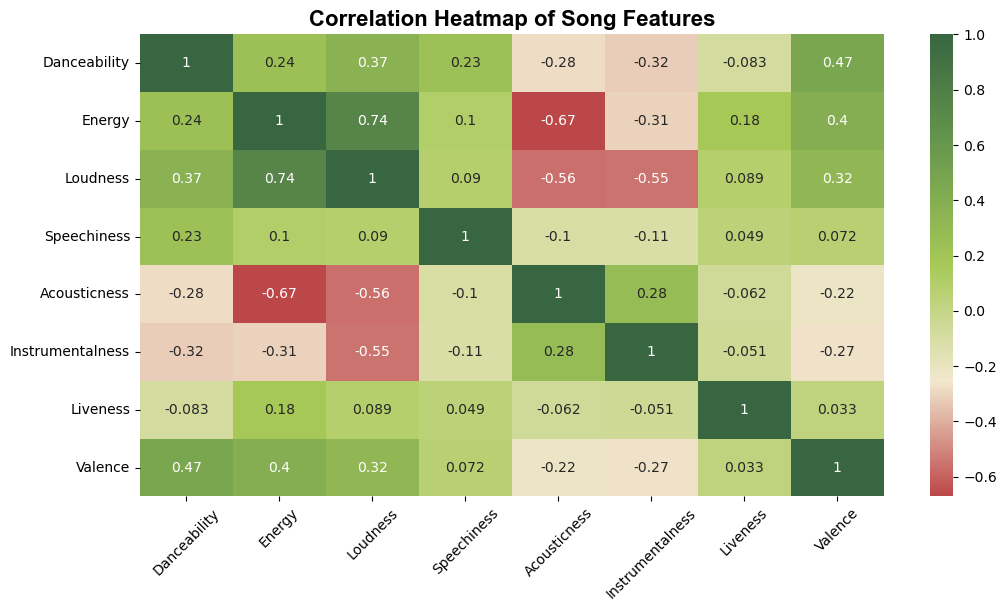

In [26]:
# Build the Heatmap
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Define your custom color palette
colors = ["#BC4749", "#F2E8CF", "#A7C957", "#6A994E", "#386641"]
custom_palette = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Create a heatmap with the custom gradient color palette
sns.heatmap(corrs, annot=True, cmap=custom_palette)

# Customization for title only
plt.title("Correlation Heatmap of Song Features", fontweight="bold", fontsize=16, fontfamily="Arial")

# Rotate X Ticks
plt.xticks(rotation=45)

# Show/Save the Graph
plt.show()

## Question 4: Are high liveness songs generally more popular on YouTube, and are low liveness songs generally more popular on Spotify?

In [28]:
data = pd.read_csv(filepath)
data = data.drop(columns=['Unnamed: 0', 'Url_spotify', 'Uri', 'Url_youtube', 'Description'])
data.info()
custom_palette = sns.color_palette(["#386641", "#BC4749", "#A7C957", "#F2E8CF", "#6A994E"])
sns.set_palette(custom_palette)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20718 non-null  object 
 1   Track             20718 non-null  object 
 2   Album             20718 non-null  object 
 3   Album_type        20718 non-null  object 
 4   Danceability      20716 non-null  float64
 5   Energy            20716 non-null  float64
 6   Key               20716 non-null  float64
 7   Loudness          20716 non-null  float64
 8   Speechiness       20716 non-null  float64
 9   Acousticness      20716 non-null  float64
 10  Instrumentalness  20716 non-null  float64
 11  Liveness          20716 non-null  float64
 12  Valence           20716 non-null  float64
 13  Tempo             20716 non-null  float64
 14  Duration_ms       20716 non-null  float64
 15  Title             20248 non-null  object 
 16  Channel           20248 non-null  object

In [29]:
df = data.drop(columns=["Album", "Album_type", "Key", "Loudness", "Speechiness", "Valence", "Danceability", "Acousticness",
                          "Instrumentalness", "Tempo", "Duration_ms", "Channel", "Likes", "Comments", "Licensed", "official_video"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Artist    20718 non-null  object 
 1   Track     20718 non-null  object 
 2   Energy    20716 non-null  float64
 3   Liveness  20716 non-null  float64
 4   Title     20248 non-null  object 
 5   Views     20248 non-null  float64
 6   Stream    20142 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [30]:
df2=df.dropna(how="any")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19691 entries, 0 to 20717
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Artist    19691 non-null  object 
 1   Track     19691 non-null  object 
 2   Energy    19691 non-null  float64
 3   Liveness  19691 non-null  float64
 4   Title     19691 non-null  object 
 5   Views     19691 non-null  float64
 6   Stream    19691 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.2+ MB


In [31]:
df2.head()

,Artist,Track,Energy,Liveness,Title,Views,Stream
0,Gorillaz,Feel Good Inc.,0.705,0.6130,Gorillaz - Feel Good Inc. (Official Video),693555221.0,1.040235e+09
1,Gorillaz,Rhinestone Eyes,0.703,0.0463,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,72011645.0,3.100837e+08
2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),0.923,0.1160,Gorillaz - New Gold ft. Tame Impala & Bootie B...,8435055.0,6.306347e+07
3,Gorillaz,On Melancholy Hill,0.739,0.0640,Gorillaz - On Melancholy Hill (Official Video),211754952.0,4.346636e+08
4,Gorillaz,Clint Eastwood,0.694,0.0698,Gorillaz - Clint Eastwood (Official Video),618480958.0,6.172597e+08


In [32]:
random_sample = df2.sample(n=500, random_state=1)
random_sample_sorted = random_sample.sort_values(by='Views', ascending=False)
display(random_sample_sorted)

,Artist,Track,Energy,Liveness,Title,Views,Stream
11982,Rihanna,This Is What You Came For,0.9270,0.148,"Calvin Harris, Rihanna - This Is What You Came...",2.626030e+09,1.389244e+09
13036,Katy Perry,Last Friday Night (T.G.I.F.),0.8120,0.667,Katy Perry - Last Friday Night (T.G.I.F.) (Off...,1.454602e+09,7.554063e+08
13490,Lady Gaga,Shallow,0.3850,0.231,"Lady Gaga, Bradley Cooper - Shallow (from A St...",1.410152e+09,2.004339e+09
14047,Bruno Mars,Grenade,0.5580,0.107,Bruno Mars - Grenade (Official Music Video),1.120763e+09,9.350283e+08
15254,The Weeknd,Save Your Tears,0.8260,0.543,The Weeknd - Save Your Tears (Official Music V...,1.060160e+09,1.368122e+09
...,...,...,...,...,...,...,...
5149,Sir Neville Marriner,"Boccherini: String Quintet in E Major, Op. 13 ...",0.0358,0.142,"String Quintet in E Major, Op. 13 No. 6, G. 28...",3.861000e+03,4.647688e+06
12320,Teufelskicker,96 - Tausendundein Tor! - Teil 03,0.6790,0.302,Teufelskicker - Folge 96: Tausendundein Tor! |...,3.455000e+03,1.139300e+05
12319,Teufelskicker,96 - Tausendundein Tor! - Teil 02,0.7750,0.378,Teufelskicker - Folge 96: Tausendundein Tor! |...,3.455000e+03,1.151670e+05
15003,Alex G,Change,0.3140,0.108,change - alex g (unofficial music video),6.450000e+02,1.417954e+07


In [33]:
x_values = random_sample_sorted["Liveness"]
y_values = random_sample_sorted["Stream"]
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

y = -7854483.34x + 141828657.44


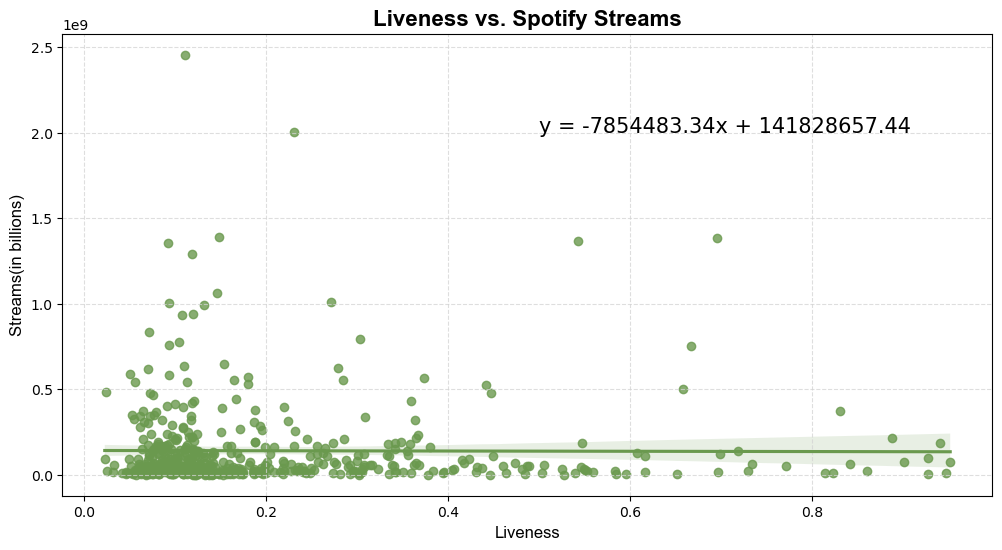

In [34]:
plt.figure(figsize=(12, 6))

sns.regplot(data=random_sample_sorted, x="Liveness", y="Stream", x_ci='ci', scatter=True, fit_reg=True, ci=95, color="#6A994E")
plt.xlabel("Liveness", fontfamily="Arial", fontsize=12)
plt.ylabel("Streams(in billions)", fontfamily="Arial", fontsize=12)
plt.title("Liveness vs. Spotify Streams", fontweight="bold", fontsize=16, fontfamily="Arial")
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)

plt.annotate(line_eq, (0.5, 2.0e9), fontsize=15, color="black")
plt.show()

In [35]:
x_values = random_sample_sorted["Liveness"]
y_values = random_sample_sorted["Views"]
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept 
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

y = 64445742.55x + 81872801.4


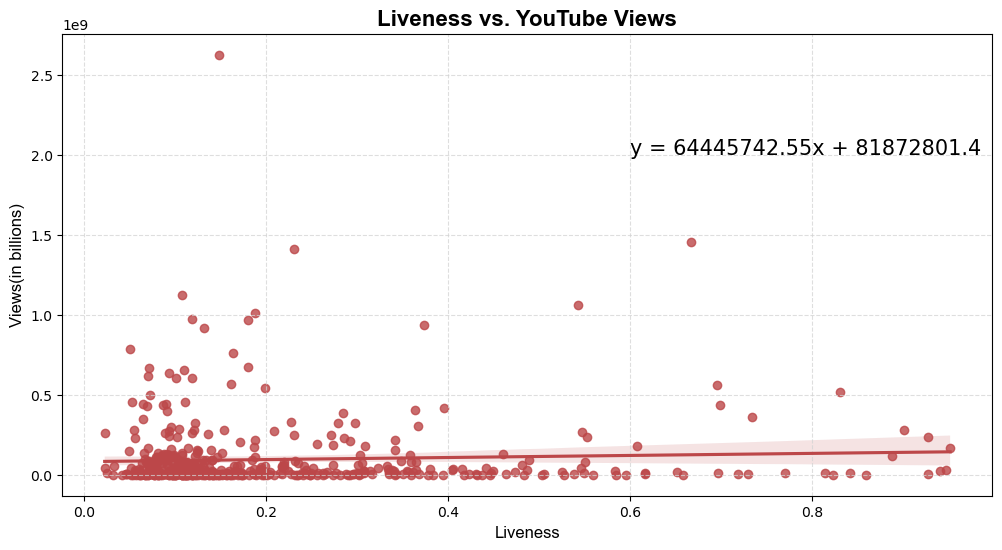

In [36]:
plt.figure(figsize=(12, 6))

sns.regplot(data=random_sample_sorted, x="Liveness", y="Views", x_ci='ci', scatter=True, fit_reg=True, ci=95, color="#BC4749")

plt.xlabel("Liveness", fontfamily="Arial", fontsize=12)
plt.ylabel("Views(in billions)", fontfamily="Arial", fontsize=12)
plt.title("Liveness vs. YouTube Views", fontweight="bold", fontsize=16, fontfamily="Arial")
plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
plt.annotate(line_eq, (0.6, 2.0e9), fontsize=15, color="black")
plt.show()